In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import abc_load as abc
get_ipython().run_line_magic('matplotlib', 'inline') 

# Load brain3 data

In [3]:
# load all cells in the brain - realigned just loads faster version here
obs = abc.get_combined_metadata(realigned=True, version="20230830", drop_unused=False)
obs.columns

Index(['brain_section_label', 'cluster_alias', 'average_correlation_score',
       'x_section', 'y_section', 'z_section', 'neurotransmitter', 'class',
       'subclass', 'supertype', 'cluster', 'x_reconstructed',
       'y_reconstructed', 'z_reconstructed', 'parcellation_index', 'x_ccf',
       'y_ccf', 'z_ccf', 'parcellation_division', 'parcellation_structure',
       'parcellation_substructure', 'slice_int', 'x_ccf_realigned',
       'y_ccf_realigned', 'z_ccf_realigned', 'parcellation_index_realigned',
       'parcellation_division_realigned', 'parcellation_structure_realigned',
       'parcellation_substructure_realigned', 'left_hemisphere',
       'left_hemisphere_realigned'],
      dtype='object')

## load CCF structures

In [4]:
realigned=False
ccf_polygons = abc.get_ccf_labels_image(resampled=True, realigned=realigned)
if realigned:
    ccf_label = 'parcellation_substructure_realigned'
    coords = 'section'
else:
    ccf_label = 'parcellation_substructure'
    coords = 'reconstructed'

## Preprocessing

### Subset to thalamus & neurons

In [5]:
# get thalamus CCF substructure names
th_names = abc.get_thalamus_substructure_names()
th_subregion_names = list(set(th_names).difference(['TH-unassigned']))

In [6]:
# remove non-neuronal and some other outlier non-thalamus types
obs_neurons = abc.filter_adata_by_class(obs, filter_midbrain=False)

In [7]:
# filter to thalamus boundaries (add a buffer here if wanted)
filter_buffer = 0  # 5
obs_th_neurons = abc.filter_by_thalamus_coords(obs_neurons, 
                                               realigned=realigned, 
                                               buffer=filter_buffer)
obs_th_strict = obs_th_neurons

### Set TH sections

In [8]:
section_col = 'z_section'
sections_all = sorted(obs_th_neurons[section_col].unique())

In [9]:
# 3 sections that representatively span the AP axis of the thalamus
sections_GRC = [6.4, 7.2, 8.0] # 7.8 - dropped due to layout contraints on the poster

### Precalculate CCF boundaries

In [10]:
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_polygons, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )
# can skip and def as none to calculate on the fly
# ccf_boundaries = None

# View CCF Structures

## View CCF as in ARA

I want to be able to generate the view you get from the ARA, but subset to just the thalamus.

Done:
1. Implemented a shape_palette='allen_reference_atlas' option that colors all CCF regions with a single salmon color that is used by the ARA for many of the thalalmic nuclei (#FE8084)

TODO
1. Confirm hex colors from ABC atlas metadata (used Illustratoyr eyedropper of ARA screenshot)
2. Add Allen Reference Atlas labels to plot on top of the centroid(?) of the nucleus
3. Use different salmon shades for the appropriate nuclei, as done in the actual ARA images

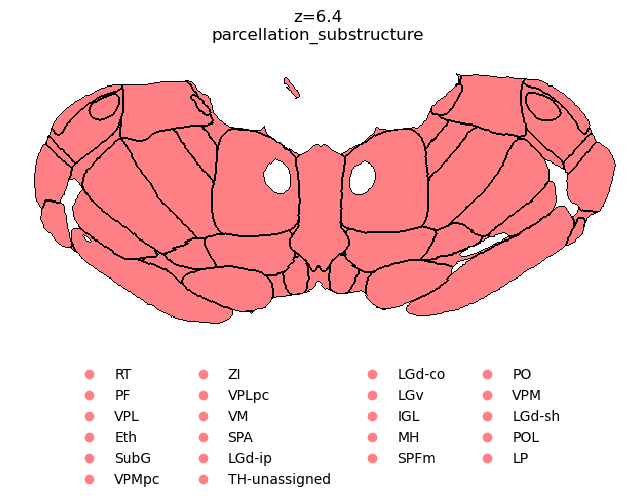

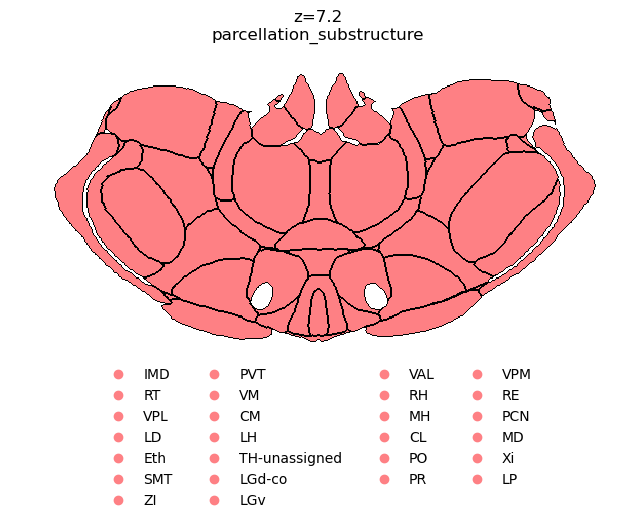

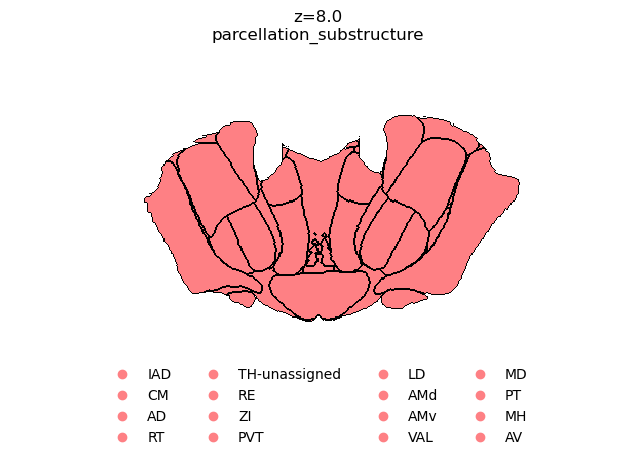

In [11]:
cplots.plot_ccf_overlay(obs_th_neurons.iloc[[],:], # no foreground cells; just the ccf shapes
                        ccf_polygons, sections=sections_GRC, point_hue=ccf_label, 
                        highlight='all', legend='ccf',
                        shape_palette='allen_reference_atlas',
                        section_col=section_col,
                        x_col = 'x_'+coords,
                        y_col = 'y_'+coords,
                        bg_shapes=False, min_section_count=0, 
                        boundary_img=ccf_boundaries);

## view taxonomy labels over CCF

# View Cell Types + CCF Overlay

## Select thalamus celltype subsets

In [12]:
subclasses_all = obs_th_strict['subclass'].value_counts().loc[lambda x: x>100].index
print(f'{len(subclasses_all) = }')

supertypes_all = obs_th_strict['supertype'].value_counts().loc[lambda x: x>20].index
print(f'{len(supertypes_all) = }')

len(subclasses_all) = 21
len(supertypes_all) = 103


In [13]:
supertypes_from_subclasses = obs_th_neurons.loc[
    lambda df: df['subclass'].isin(subclasses_all), 'supertype'].unique()

print(f'{supertypes_from_subclasses.shape[0] = }')

print(f'{len(supertypes_all.intersection(supertypes_from_subclasses)) = }')

supertypes_from_subclasses.shape[0] = 100
len(supertypes_all.intersection(supertypes_from_subclasses)) = 94


In [14]:
clusters_from_subclasses = obs_th_neurons.loc[
            lambda df: df['subclass'].isin(subclasses_all), 'cluster'].unique()
print(f'{clusters_from_subclasses.shape[0] = }')

clusters_from_subclasses.shape[0] = 437


### Figure parameters

#### Set celltype color palettes

In [15]:
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['subclass','supertype','cluster']}

In [62]:
palette_df = pd.read_csv('/code/resources/cluster_palette_glasbey.csv')
cluster_palette = dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

#### Set plot kwargs

In [17]:
kwargs = dict(
    bg_cells=obs_th_strict,
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=3, 
    shape_palette='dark_outline',
    boundary_img=ccf_boundaries
)

#### Get obs with TH subclasses

In [18]:
obs_th_subclasses = obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all)]

## Subclass + CCF plots

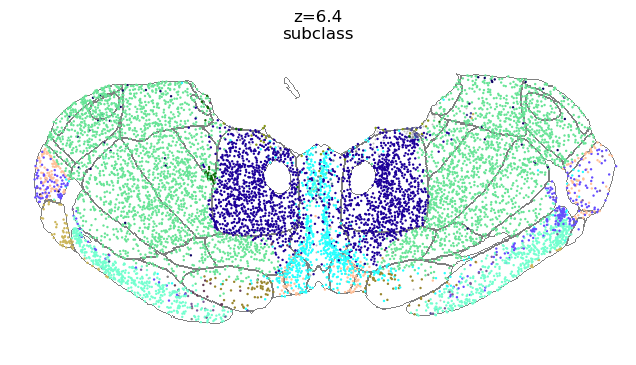

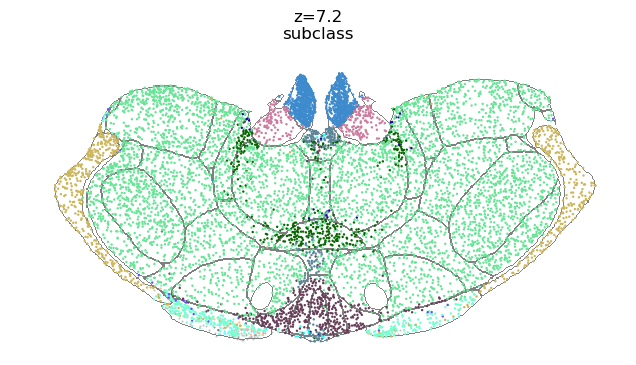

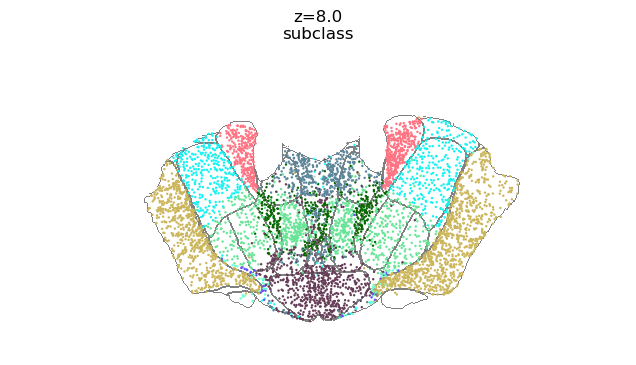

In [19]:
subclass_figs = cplots.plot_ccf_overlay(obs_th_subclasses, ccf_polygons, 
                                        point_hue='subclass', 
                                        sections=sections_GRC,
                                        point_palette=abc_palettes['subclass'],
                                        legend=None, #'cells', 
                                        **kwargs)

# save as pdfs
for i, fig in enumerate(subclass_figs):
    sec = int(sections_GRC[i]*10)
    fig.savefig(f'/results/ccf_subclass_z{sec}.pdf', transparent=True, 
                bbox_inches='tight')

## Supertype + CCF plots - NOT DISPLAYING FOR GRC

In [20]:
# # Not displaying supertypes on the GRC poster for simplicity
# obs = obs_th_neurons.loc[lambda df: df['supertype'].isin(supertypes_all)]

# cplots.plot_ccf_overlay(obs_th_subclasses, ccf_polygons, 
#                         point_hue='supertype', sections=sections_GRC,
#                         point_palette=palettes['supertype'],
#                         legend=None, #'cells', 
#                         **kwargs);

# # save as pdfs
# for i, fig in enumerate(subclass_figs):
#     sec = int(sections_GRC[i]*10)
#     fig.savefig(f'/results/ccf_supertype_z{sec}.pdf', transparent=True, 
#                 bbox_inches='tight')

## Cluster + CCF plots

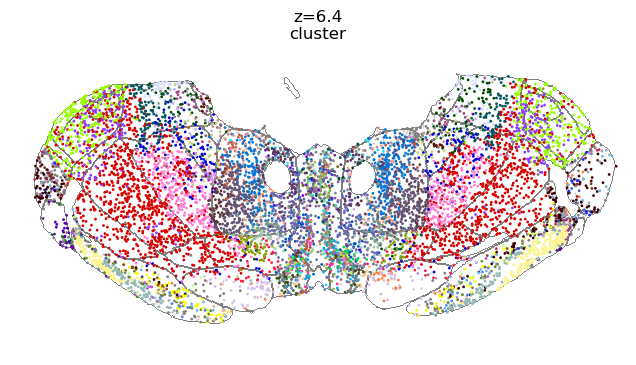

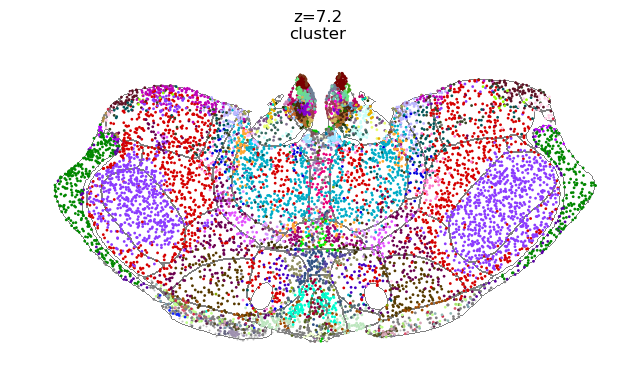

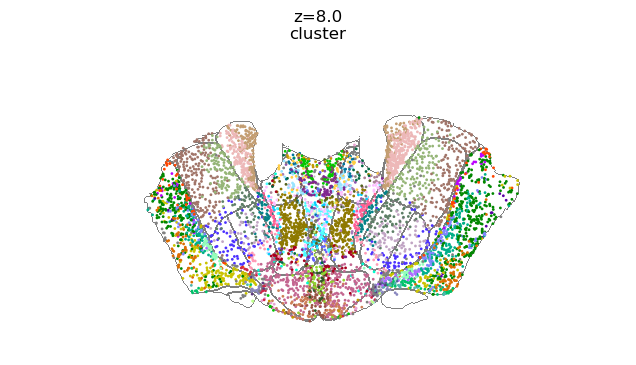

In [54]:
cluster_figs = cplots.plot_ccf_overlay(obs_th_subclasses, ccf_polygons, 
                                       sections=sections_GRC,
                                       point_hue='cluster', 
                                       point_palette=cluster_palette,
                                       legend=None, 
                                       **kwargs);

# save as
for i, fig in enumerate(cluster_figs):
    sec_name = int(sections_GRC[i]*10)
    fig.savefig(f'/results/ccf_cluster_z{sec}.pdf', transparent=True,  
                bbox_inches='tight')

# Specific nuclei examples

## AD & AV clusters

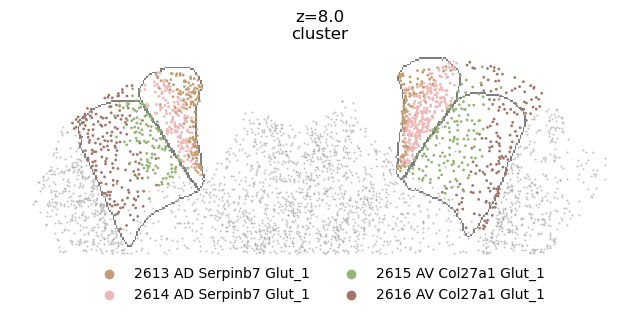

In [22]:
ant_sections = [8.0]
ad_av_nuclei = ['AD', 'AV']
ad_av_clusters = [str(x) for x in list(range(2613, 2616+1))]
ad_av_obs = obs_th_neurons.loc[lambda df: df['cluster'].str[:4].isin(ad_av_clusters)]

kwargs = dict(
    bg_cells=obs_th_strict,
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=4, 
    shape_palette='dark_outline',
    boundary_img=ccf_boundaries
)

figs = cplots.plot_ccf_overlay(ad_av_obs, ccf_polygons, sections=ant_sections,
                               point_hue='cluster', point_palette=cluster_palette,
                               ccf_names=['AD', 'AV'], legend='cells',
                               custom_xy_lims=[3.7,7.6, 5.9, 4.6],
                               **kwargs);
figs[0].savefig(f'/results/abc_ccf_AD_AV_clusters_z{int(ant_sections[0]*10)}.pdf', 
               bbox_inches='tight')

## MD

In [39]:
nucleus='MD'
md_sections = [6.8, 7.0, 7.2]
md_xy_lims = [4.3, 6.8, 6.2, 4.4]
md_kwargs = dict(
                bg_cells=obs_th_strict,
                section_col=section_col,
                x_col = 'x_'+coords,
                y_col = 'y_'+coords,
                s=10, 
                shape_palette='dark_outline',
                boundary_img=ccf_boundaries
            )

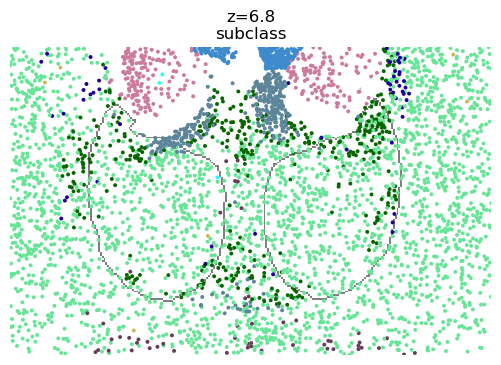

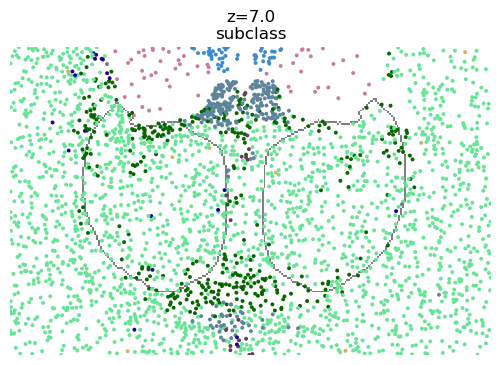

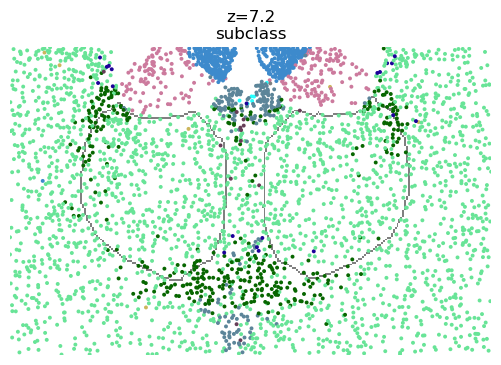

In [24]:
taxonomy_level = 'subclass'
md_figs = cplots.plot_ccf_overlay(obs_th_subclasses, 
                                  ccf_polygons, 
                                  sections=md_sections,
                                  point_hue=taxonomy_level, 
                                  point_palette=abc_palettes[taxonomy_level],
                                  ccf_names=[nucleus],
                                  custom_xy_lims=md_xy_lims,
                                  legend=None, 
                                  **md_kwargs);

for i, fig in enumerate(md_figs):
    sec = int(md_sections[i]*10)
    fig.savefig(f'/results/ccf_MD_{taxonomy_level}_z{sec}.pdf', transparent=True,
                bbox_inches='tight')

In [25]:
# taxonomy_level = 'supertype'
# md_figs = cplots.plot_ccf_overlay(obs_th_subclasses, 
#                                   ccf_polygons, 
#                                   sections=md_sections,
#                                   point_hue=taxonomy_level, 
#                                   point_palette=abc_palettes[taxonomy_level],
#                                   ccf_names=[nucleus],
#                                   custom_xy_lims=md_xy_lims,
#                                   legend=None, 
#                                   **md_kwargs);

# for i, fig in enumerate(md_figs):
#     sec = int(md_sections[i]*10)
#     fig.savefig(f'/results/ccf_MD_{taxonomy_level}_z{sec}.pdf', transparent=True,
#                 bbox_inches='tight')

In [75]:
# clusters with >=1% of cells in the MD
# see metrics notebook for code
md_clusters = ['2678 TH Prkcd Grin2c Glut_10',
                 '2648 TH Prkcd Grin2c Glut_1',
                 '2635 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2681 TH Prkcd Grin2c Glut_12',
                 '2644 CM-IAD-CL-PCN Sema5b Glut_4',
                 '2682 TH Prkcd Grin2c Glut_12',
                 '2683 TH Prkcd Grin2c Glut_13',
                 '2638 CM-IAD-CL-PCN Sema5b Glut_2',
                 '2677 TH Prkcd Grin2c Glut_10',
                 '2636 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2664 TH Prkcd Grin2c Glut_6',
                 '2687 TH Prkcd Grin2c Glut_13',
                 '2636 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2664 TH Prkcd Grin2c Glut_6',
                 '2687 TH Prkcd Grin2c Glut_13',
                 '2639 CM-IAD-CL-PCN Sema5b Glut_2',
                 '2633 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2674 TH Prkcd Grin2c Glut_9',
                 '2634 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2643 CM-IAD-CL-PCN Sema5b Glut_4',
                 '2662 TH Prkcd Grin2c Glut_6',
                 '2622 PVT-PT Ntrk1 Glut_2',
                 '2621 PVT-PT Ntrk1 Glut_2',
                 '2642 CM-IAD-CL-PCN Sema5b Glut_3',
                 '2637 CM-IAD-CL-PCN Sema5b Glut_2',
                 '2663 TH Prkcd Grin2c Glut_6',
                 '2632 PVT-PT Ntrk1 Glut_6'           
                   ]
md_clusters_1pct = md_clusters[:13]
md_clusters_2pct = md_clusters[:8]
md_clusters_5pct = md_clusters[:3]

obs_md = obs_th_neurons.loc[lambda df: df['cluster'].isin(md_clusters)]
obs_md_1pct = obs_th_neurons.loc[lambda df: df['cluster'].isin(md_clusters_1pct)]
obs_md_2pct = obs_th_neurons.loc[lambda df: df['cluster'].isin(md_clusters_2pct)]
obs_md_5pct = obs_th_neurons.loc[lambda df: df['cluster'].isin(md_clusters_5pct)]
obs_md_annot = abc.get_obs_from_annotated_clusters(nucleus, obs_th_neurons)

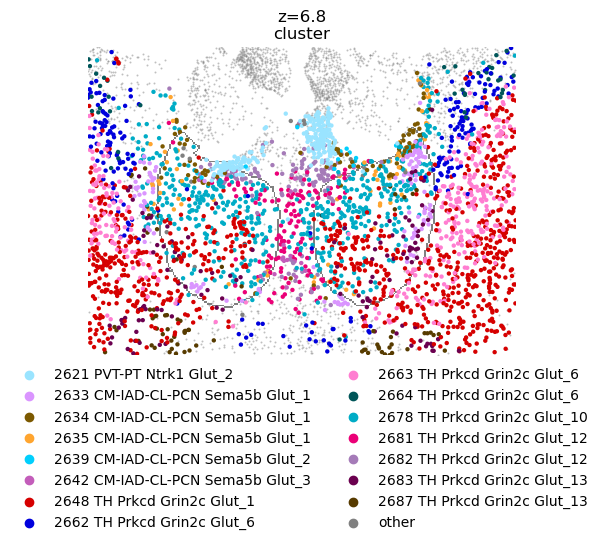

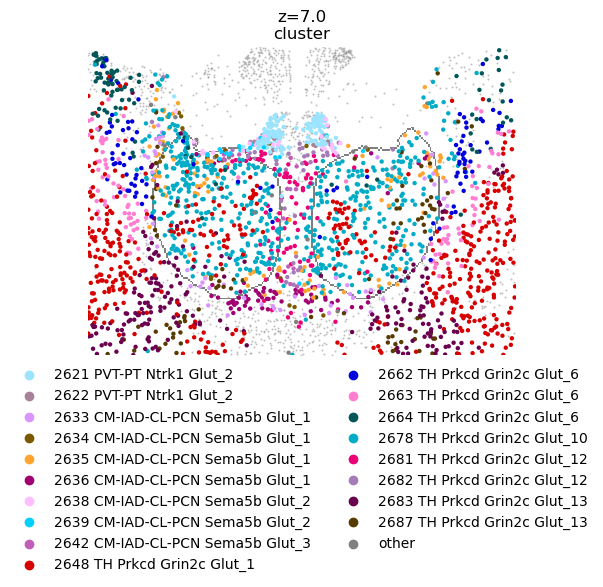

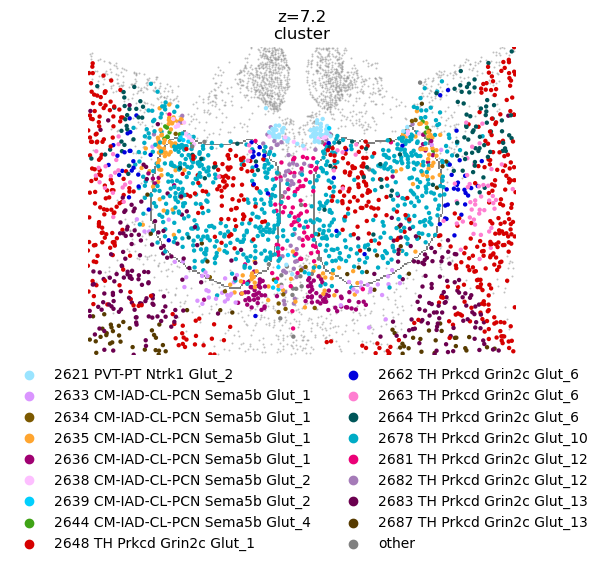

In [77]:
taxonomy_level = 'cluster'
md_figs = cplots.plot_ccf_overlay(obs_md, 
                                  ccf_polygons, 
                                  sections=md_sections,
                                  point_hue=taxonomy_level, 
                                  point_palette=cluster_palette,
                                  ccf_names=[nucleus],
                                  custom_xy_lims=md_xy_lims,
                                  legend='cells', 
                                  **md_kwargs);

for i, fig in enumerate(md_figs):
    sec = int(md_sections[i]*10)
    fig.savefig(f'/results/ccf_MD_{taxonomy_level}_z{sec}.pdf', transparent=True,
                bbox_inches='tight')

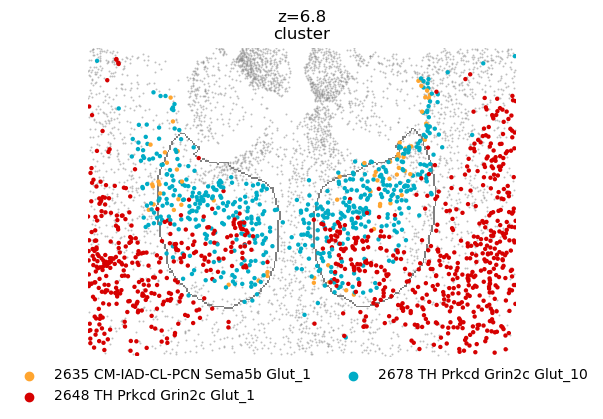

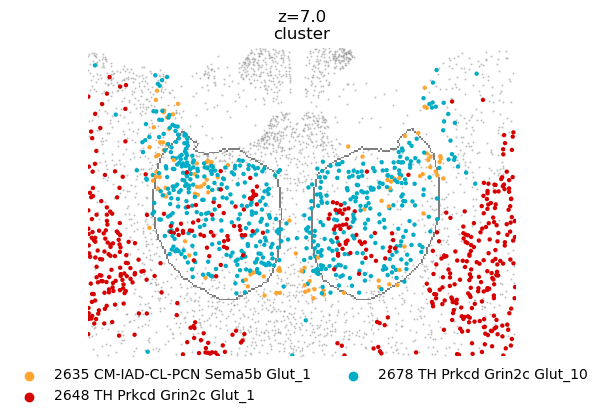

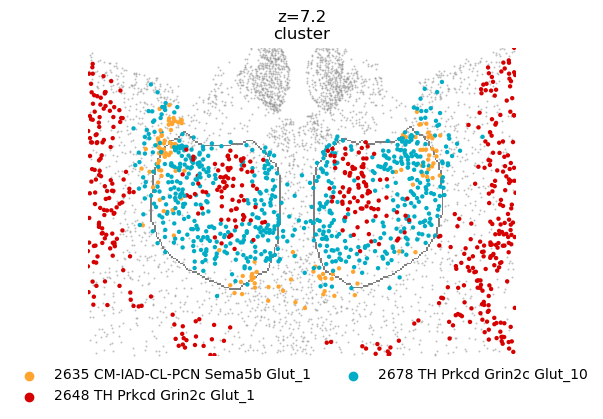

In [78]:
taxonomy_level = 'cluster'
md_figs = cplots.plot_ccf_overlay(obs_md_5pct, 
                                  ccf_polygons, 
                                  sections=md_sections,
                                  point_hue=taxonomy_level, 
                                  point_palette=cluster_palette,
                                  ccf_names=[nucleus],
                                  custom_xy_lims=md_xy_lims,
                                  legend='cells', 
                                  **md_kwargs);

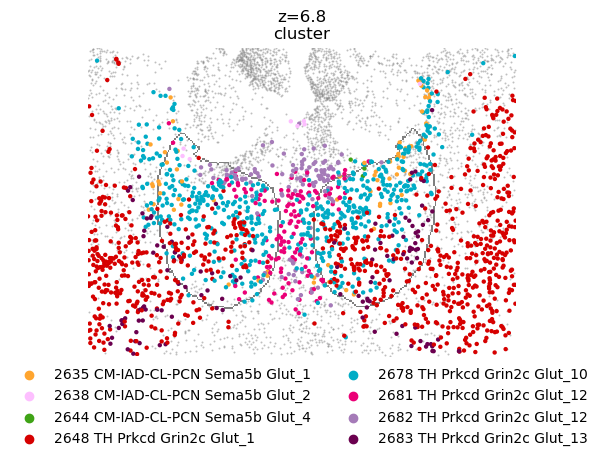

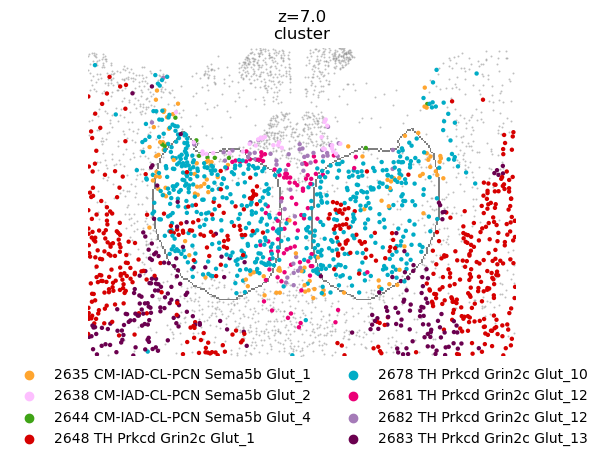

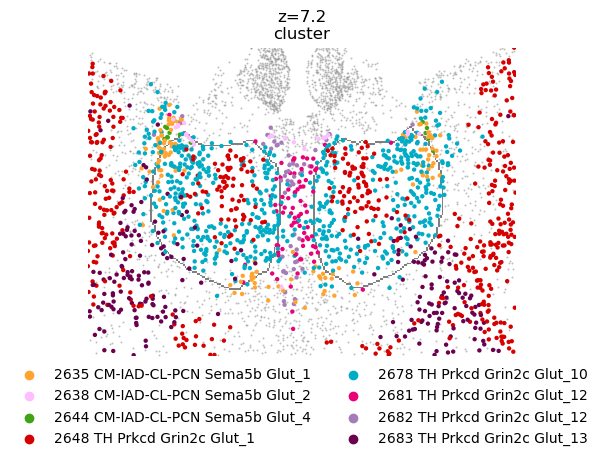

In [79]:
taxonomy_level = 'cluster'
md_figs = cplots.plot_ccf_overlay(obs_md_2pct, 
                                  ccf_polygons, 
                                  sections=md_sections,
                                  point_hue=taxonomy_level, 
                                  point_palette=cluster_palette,
                                  ccf_names=[nucleus], highlight=[nucleus],
                                  custom_xy_lims=md_xy_lims,
                                  legend='cells', 
                                  **md_kwargs);

for i, fig in enumerate(md_figs):
    sec = int(md_sections[i]*10)
    fig.savefig(f'/results/ccf_MD_8clusters_z{sec}.pdf', transparent=True,
                bbox_inches='tight')

In [80]:
# taxonomy_level = 'cluster'
# md_figs = cplots.plot_ccf_overlay(obs_md_1pct, 
#                                   ccf_polygons, 
#                                   sections=md_sections,
#                                   point_hue=taxonomy_level, 
#                                   point_palette=cluster_palette,
#                                   ccf_names=[nucleus],
#                                   custom_xy_lims=md_xy_lims,
#                                   legend='cells', 
#                                   **md_kwargs);

In [72]:
md_clust_old = ['1130 TH Prkcd Grin2c Glut_1', '1133 TH Prkcd Grin2c Glut_10',
                '1136 TH Prkcd Grin2c Glut_12', '1137 TH Prkcd Grin2c Glut_12',
                '1138 TH Prkcd Grin2c Glut_13', '1142 TH Prkcd Grin2c Glut_13',
                '1157 TH Prkcd Grin2c Glut_6', '1158 TH Prkcd Grin2c Glut_6',
                '1159 TH Prkcd Grin2c Glut_6', '1168 TH Prkcd Grin2c Glut_8']
md_clust_curr = abc.convert_taxonomy_labels(md_clust_old, 'cluster', 
                                        label_format='id_label',
                                        input_version='20230630', output_version='20230830',
                                        output_as_dict=True)
md_clust_curr

{'1130 TH Prkcd Grin2c Glut_1': '2648 TH Prkcd Grin2c Glut_1',
 '1133 TH Prkcd Grin2c Glut_10': '2678 TH Prkcd Grin2c Glut_10',
 '1136 TH Prkcd Grin2c Glut_12': '2681 TH Prkcd Grin2c Glut_12',
 '1137 TH Prkcd Grin2c Glut_12': '2682 TH Prkcd Grin2c Glut_12',
 '1138 TH Prkcd Grin2c Glut_13': '2683 TH Prkcd Grin2c Glut_13',
 '1142 TH Prkcd Grin2c Glut_13': '2687 TH Prkcd Grin2c Glut_13',
 '1157 TH Prkcd Grin2c Glut_6': '2662 TH Prkcd Grin2c Glut_6',
 '1158 TH Prkcd Grin2c Glut_6': '2663 TH Prkcd Grin2c Glut_6',
 '1159 TH Prkcd Grin2c Glut_6': '2664 TH Prkcd Grin2c Glut_6',
 '1168 TH Prkcd Grin2c Glut_8': '2673 TH Prkcd Grin2c Glut_8'}

In [73]:
abc.convert_taxonomy_labels(['2635 CM-IAD-CL-PCN Sema5b Glut_1'], 'cluster', 
                            label_format='id_label',
                            input_version='20230830', output_version='20230630',
                            output_as_dict=True)

{'2635 CM-IAD-CL-PCN Sema5b Glut_1': '1117 CM-IAD-CL-PCN Glut_1'}

## Clusters, no CCF overlay

In [32]:
# obs = obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all)]
# nuclei = ['AD', 'AV', 'AMd', 'AMv']
# kwargs = dict(
#     bg_cells=obs_th_strict,
#     section_col=section_col,
#     x_col = 'x_'+coords,
#     y_col = 'y_'+coords,
#     s=5, 
#     shape_palette='dark_outline',
#     boundary_img=ccf_boundaries
# )
# cplots.plot_ccf_overlay(obs, ccf_polygons, 
#                         point_hue='cluster', sections=[sections_GRC[1]],
#                         point_palette=palettes['cluster'],
#                         ccf_names=nuclei,
#                         legend=None, 
#                         **kwargs);

## Gene expression, no CCF overlay

In [33]:
# adata = abc.load_adata(transform='log2', subset_to_TH_ZI=True, with_metadata=True,
#                        flip_y=False, round_z=True, cirro_names=False, 
#                        with_colors=True, realigned=False, loaded_metadata=None)

# adata = abc.filter_adata_by_class(adata, filter_nonneuronal=True, 
#                                   filter_midbrain=True, 
#                                   filter_others=True)

In [34]:
# cplots.plot_expression_ccf(adata, 'Gad2', ccf_polygons, 
#                            sections=[7.2], 
#                            nuclei=['AD'], highlight=['AD'], # not in this section so result is no ccf overlays
#                            s=0.5, cmap='Blues', show_outline=False, 
#                            bg_shapes=False, axes=False,  
#                            section_col='z_reconstructed', 
#                            x_col='x_reconstructed',
#                            y_col='y_reconstructed',
#                            boundary_img=None)

In [35]:
# cplots.plot_expression_ccf(adata, 'Slc17a7', ccf_polygons, 
#                            sections=[7.2], 
#                            nuclei=['AD'], highlight=['AD'], # not in this section so result is no ccf overlays
#                            s=0.5, cmap='Blues', show_outline=False, 
#                            bg_shapes=False, axes=False,  
#                            section_col='z_reconstructed', 
#                            x_col='x_reconstructed',
#                            y_col='y_reconstructed',
#                            boundary_img=None)